In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import noise
import random

starting map:


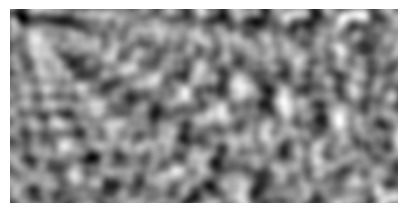

trial 10:


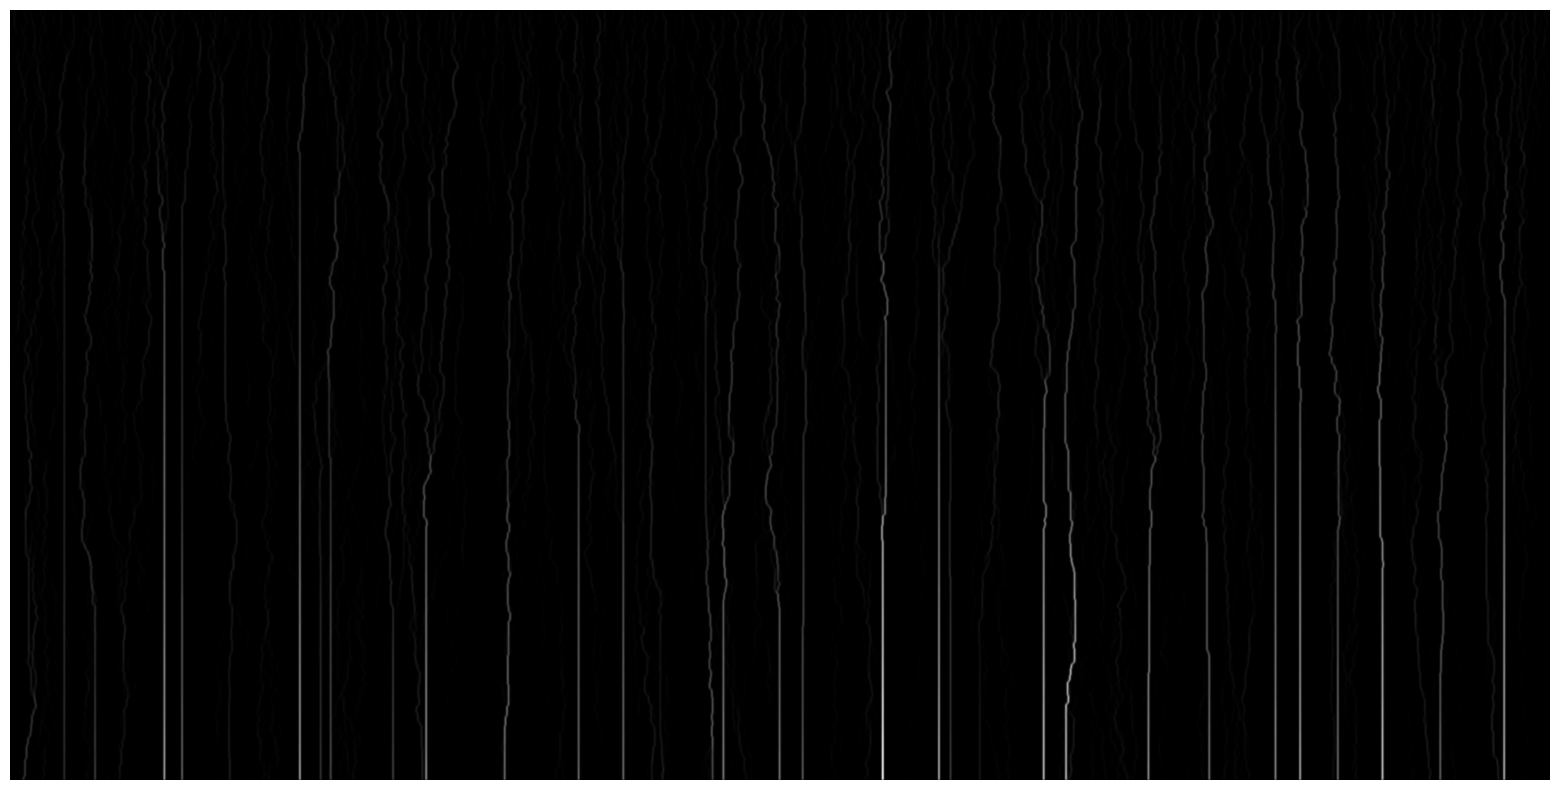

trial 20:


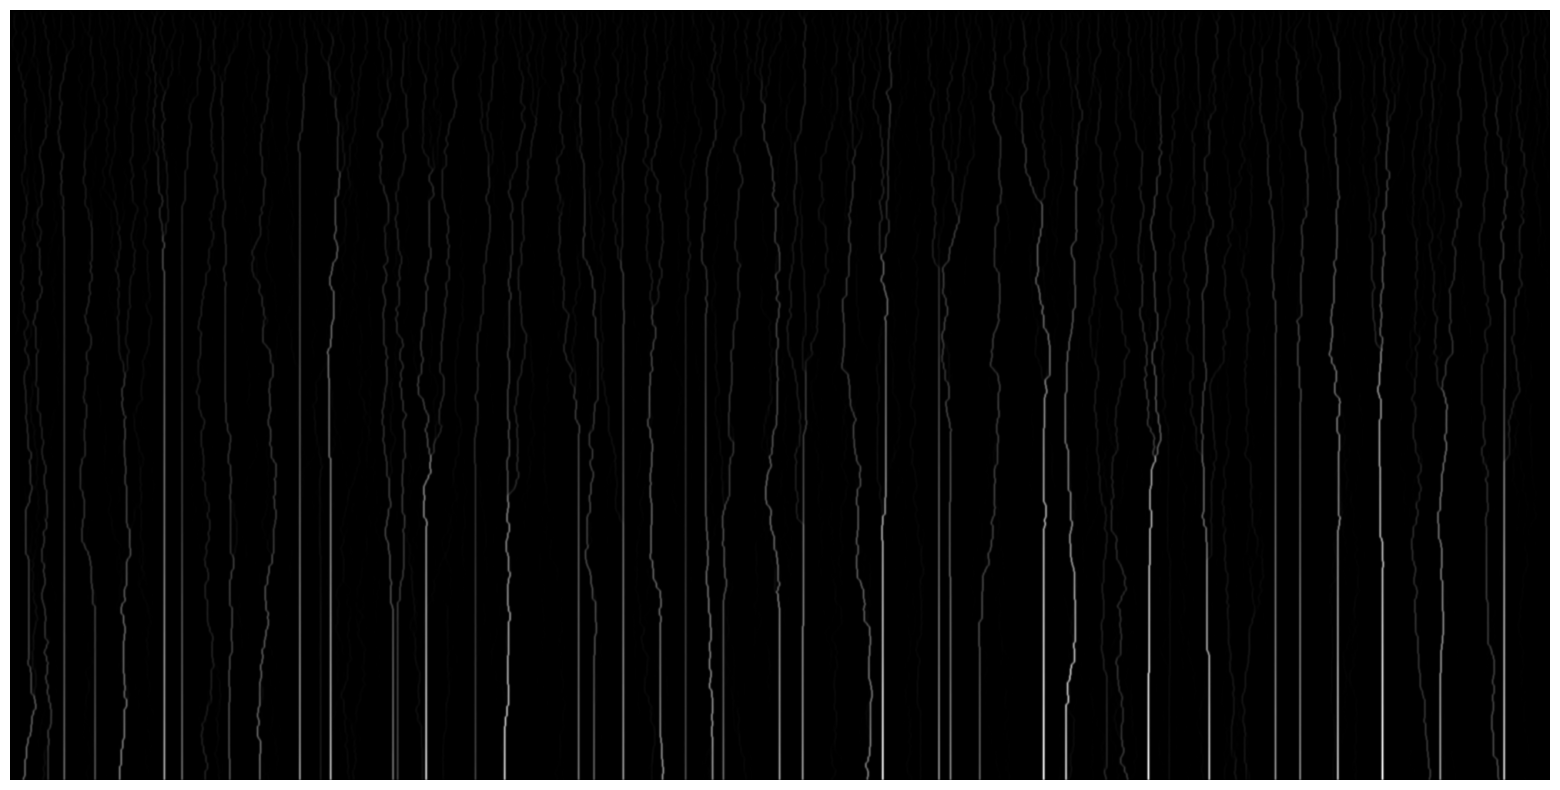

trial 30:


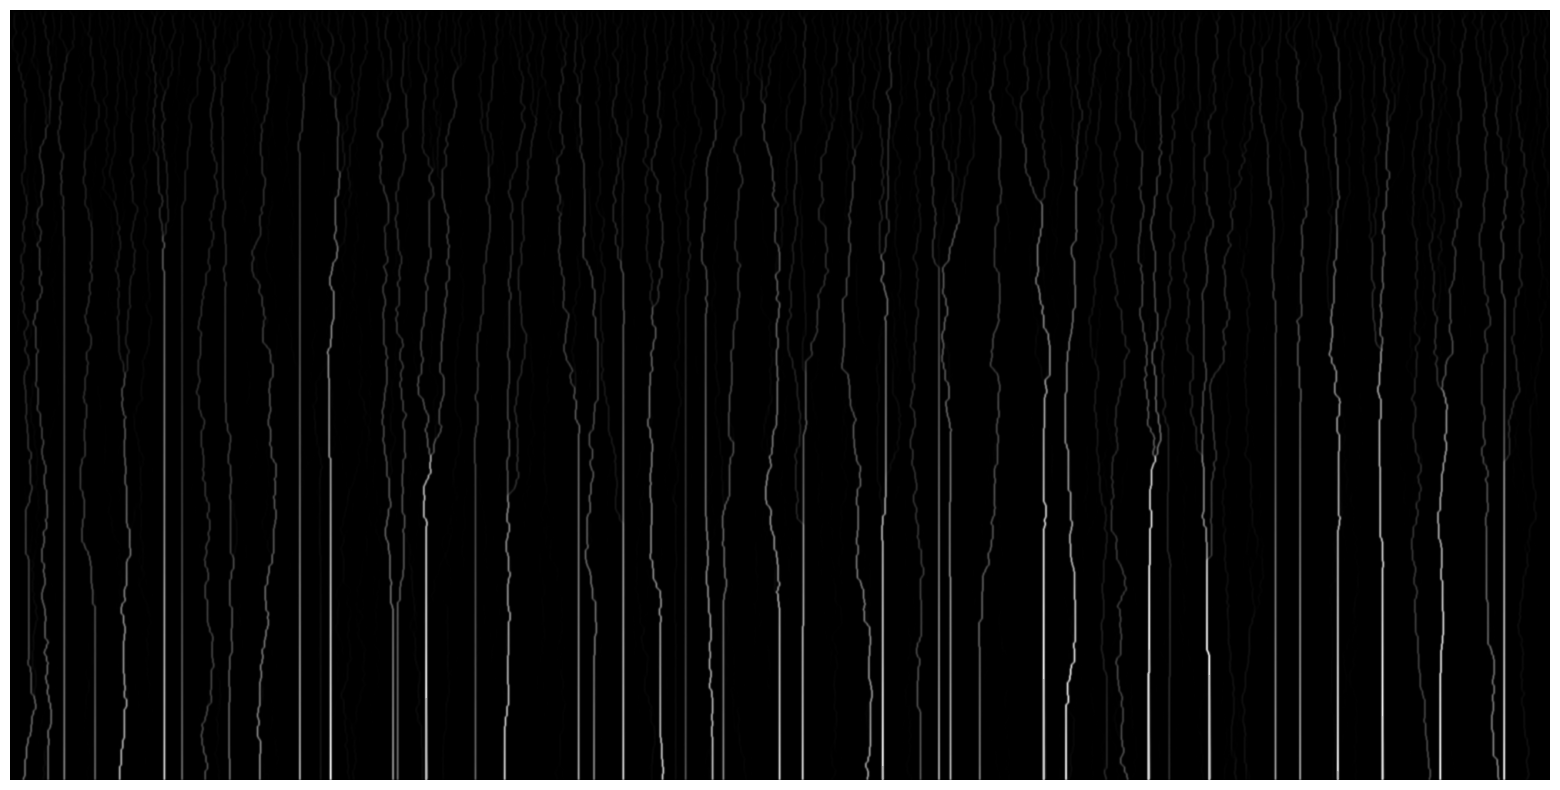

trial 40:


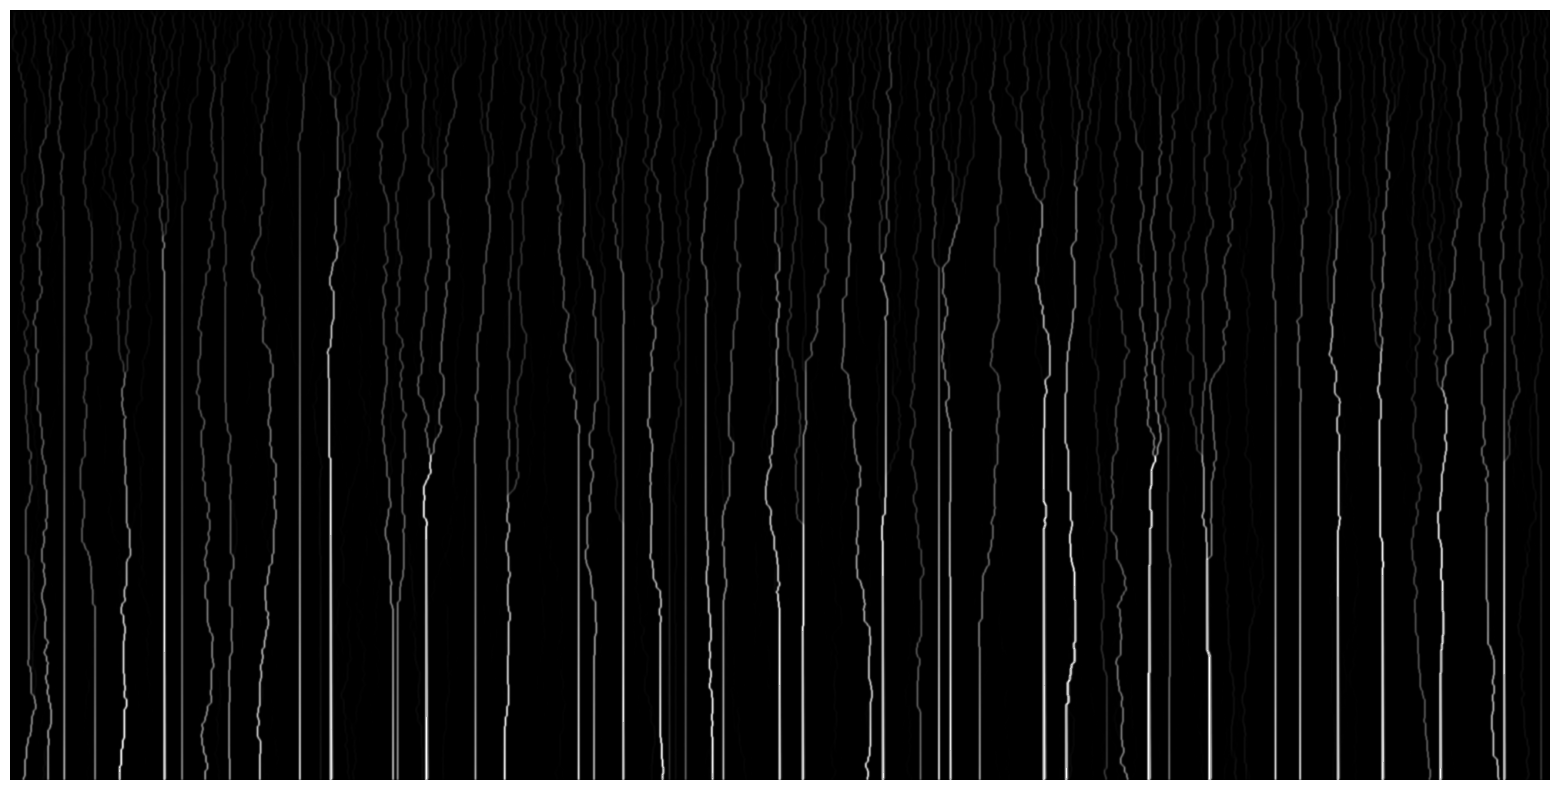

trial 50:


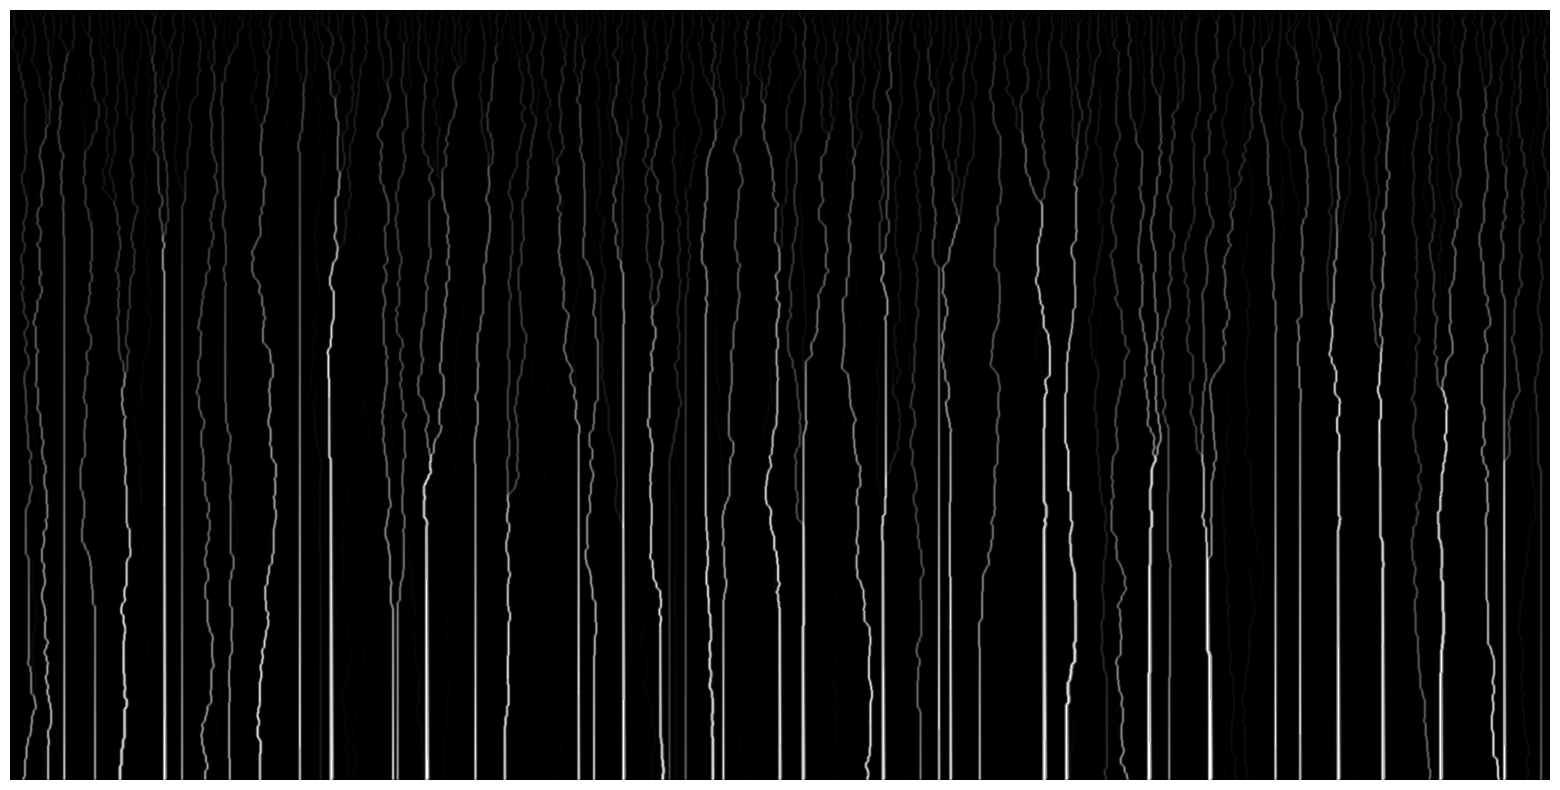

trial 60:


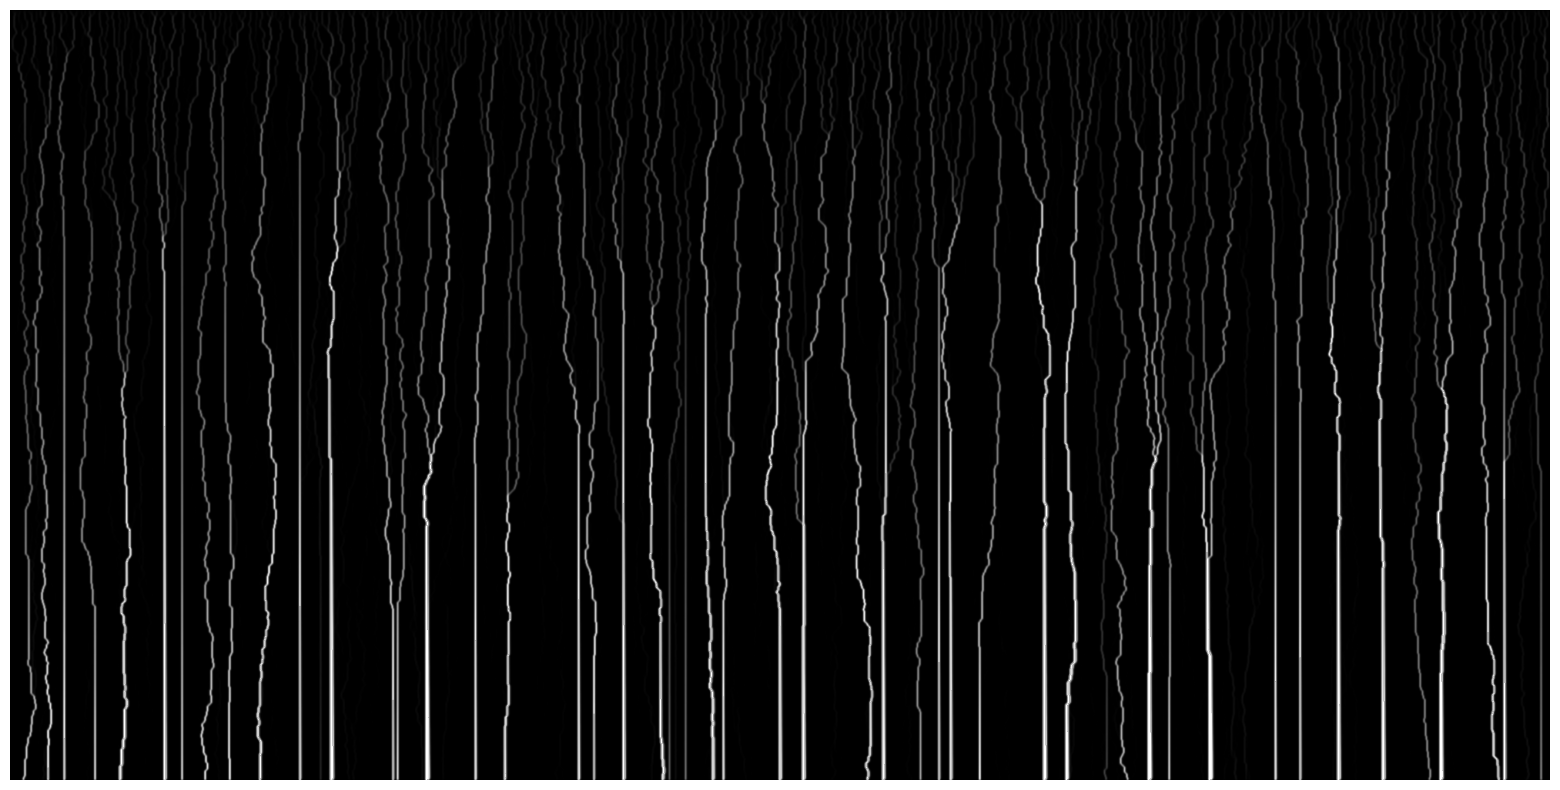

trial 70:


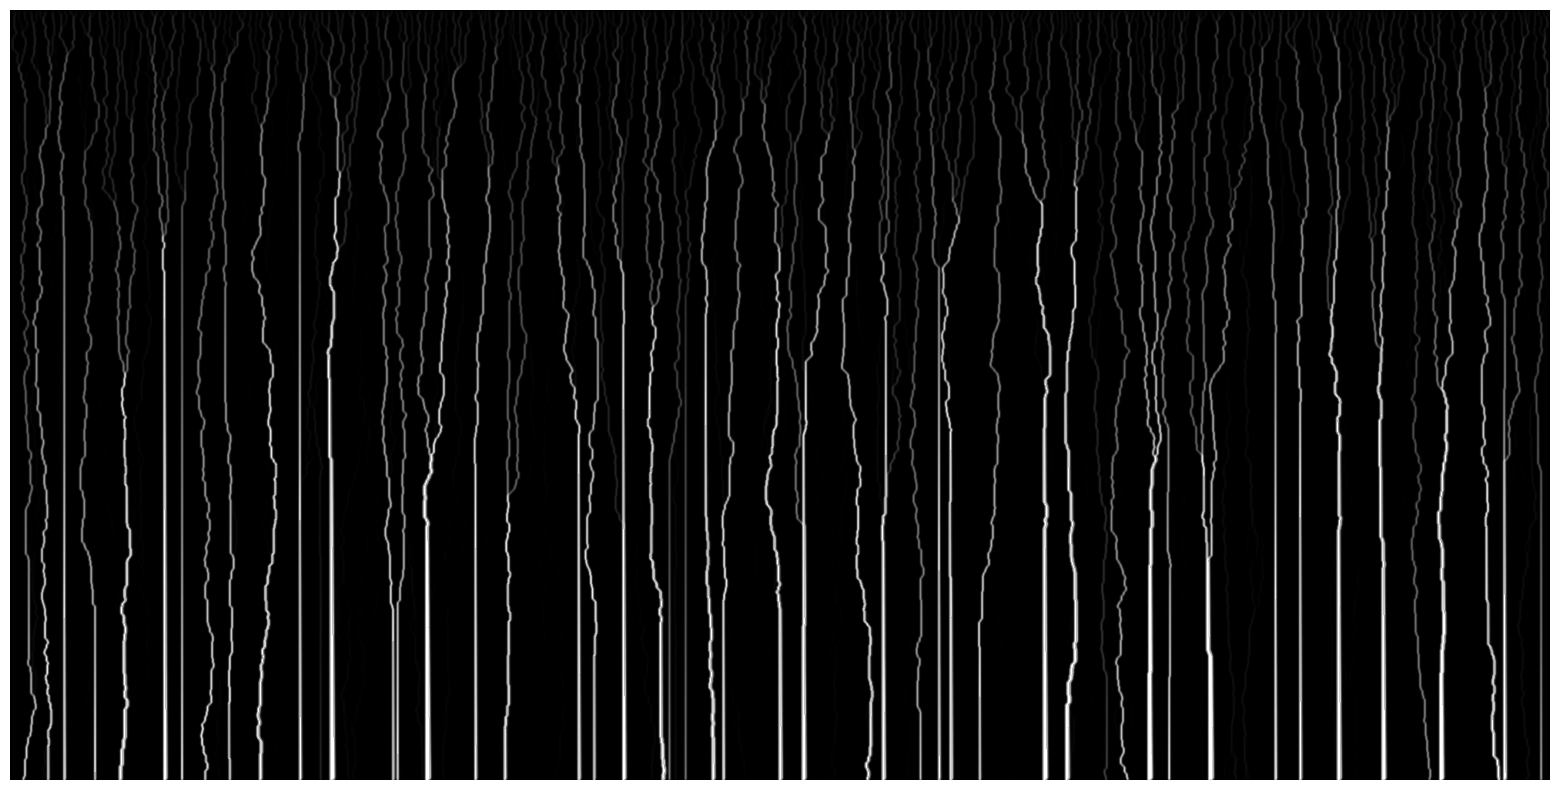

trial 80:


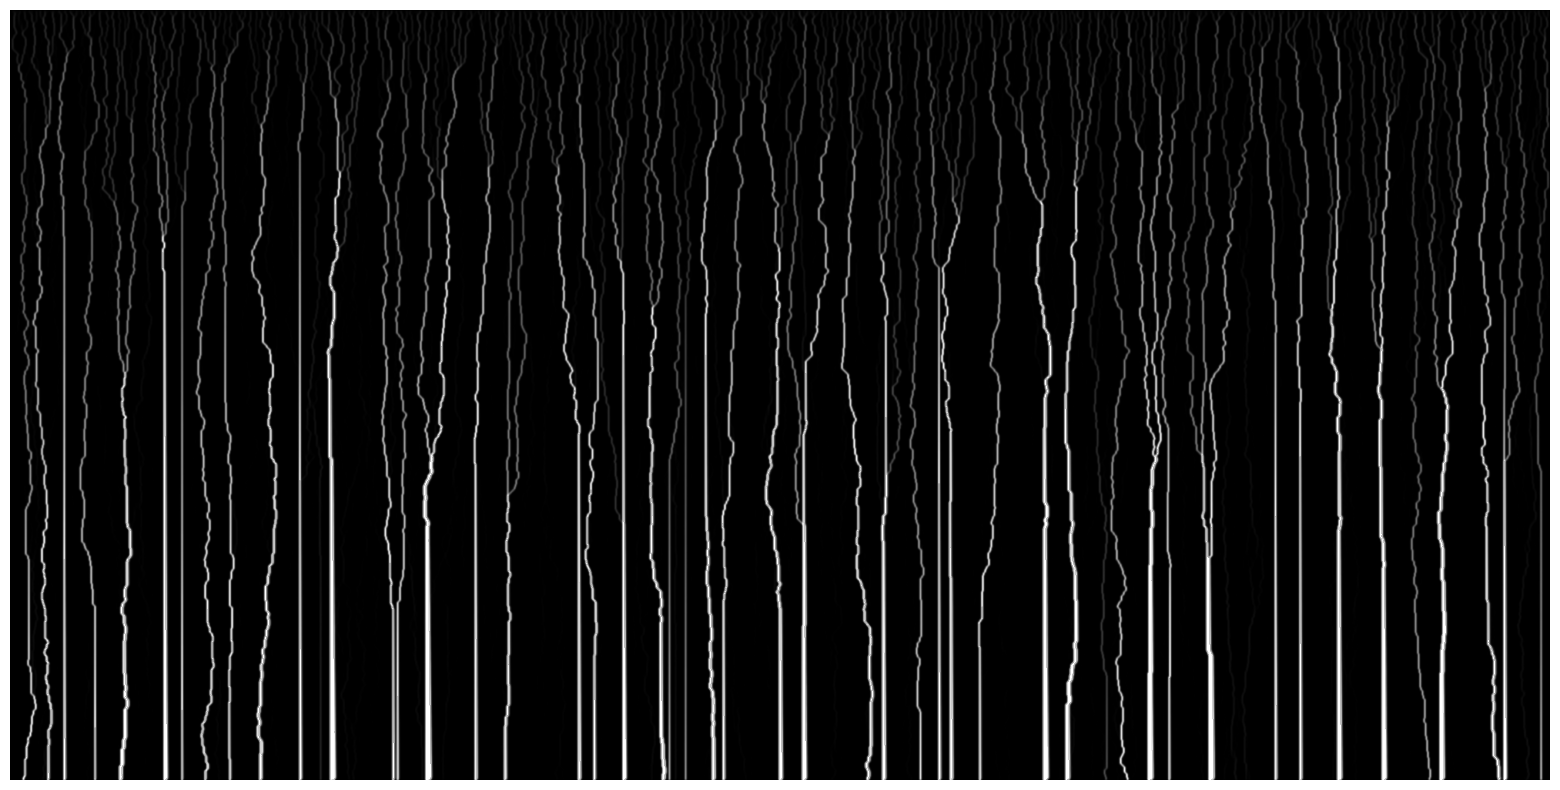

trial 90:


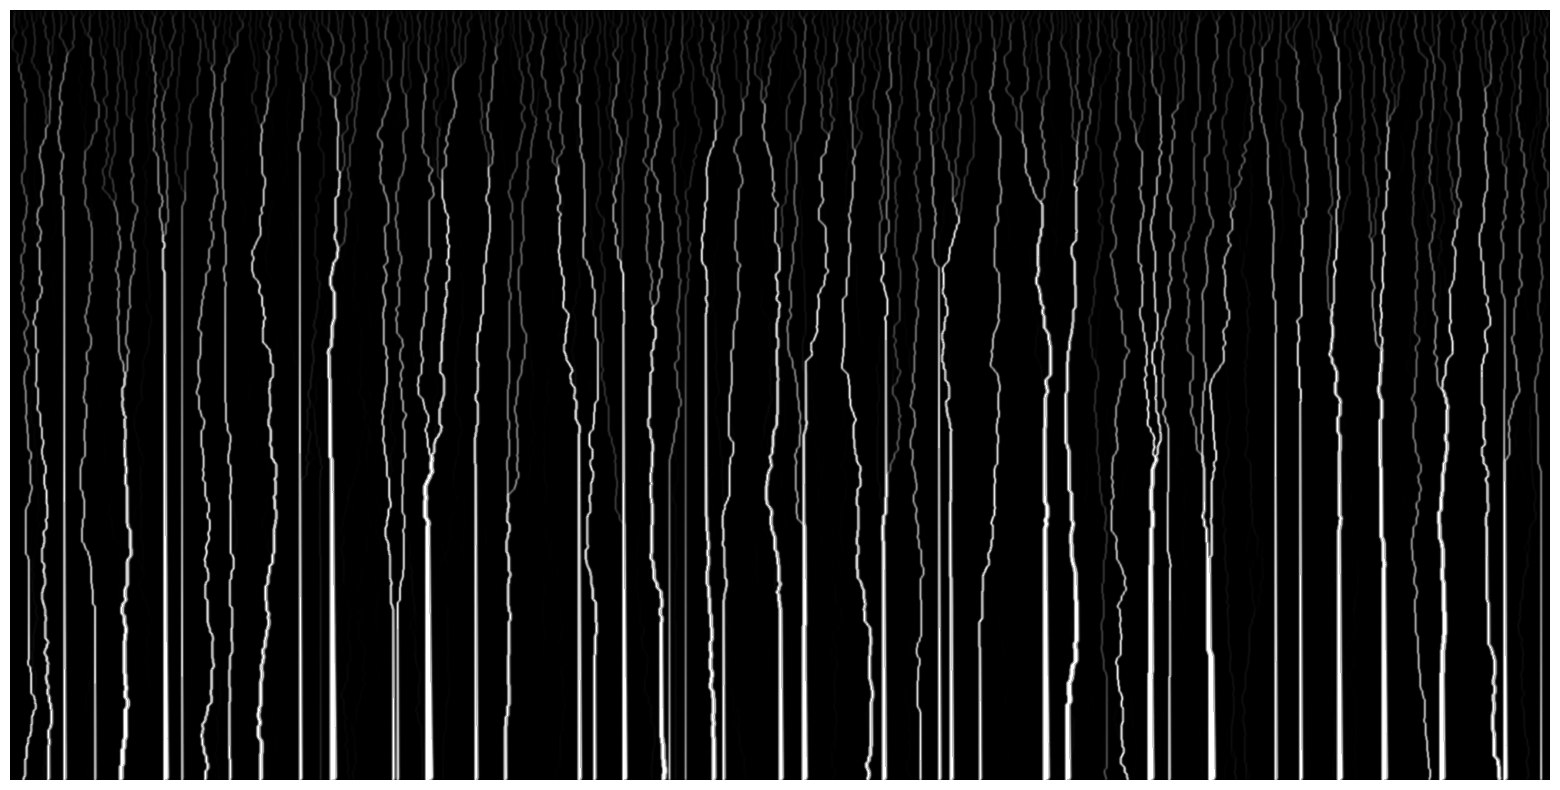

trial 100:


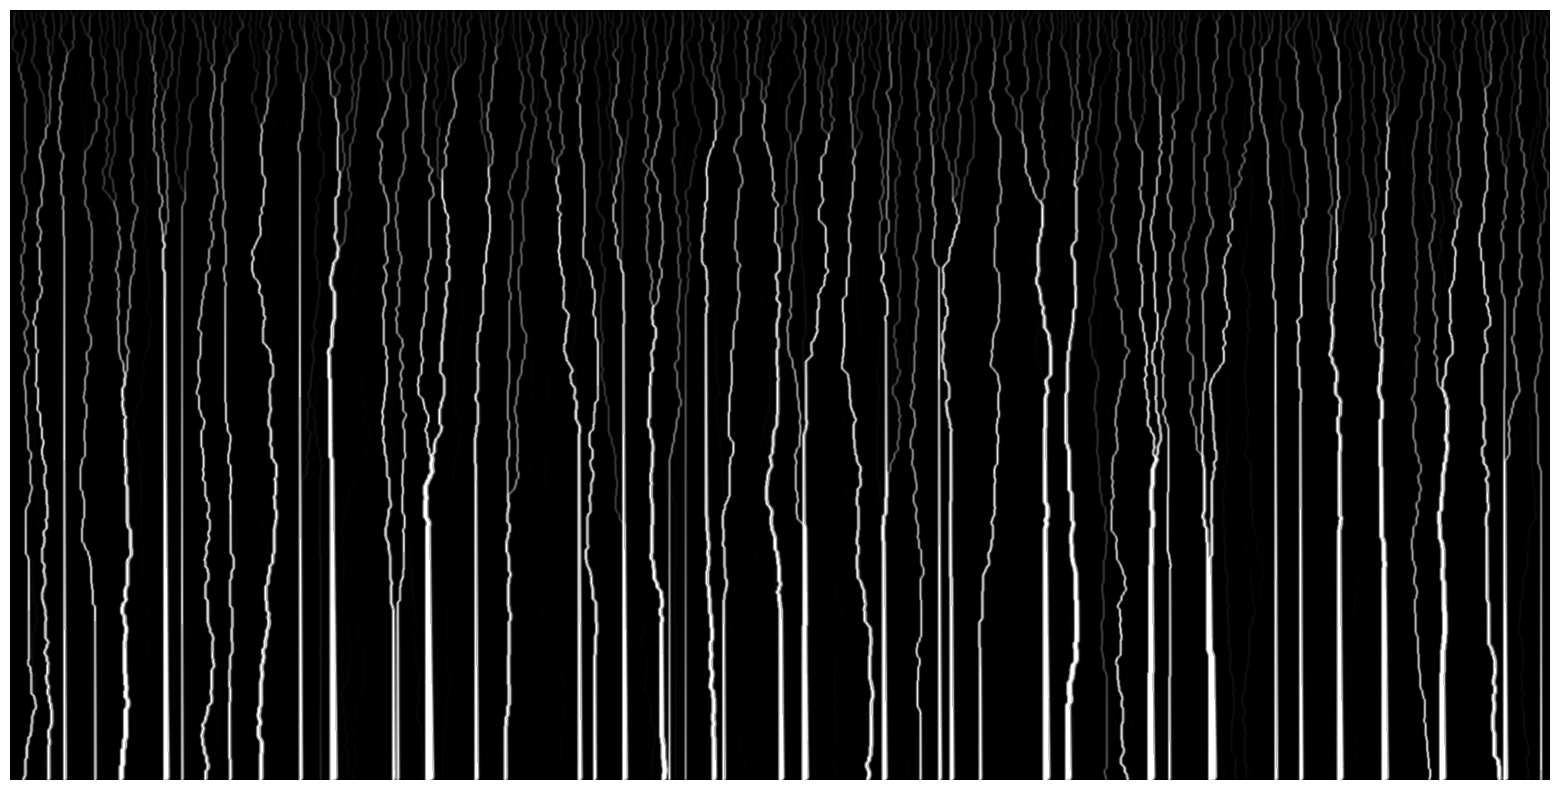

In [82]:
# --- parameters
INIT_WALKERS = 200
MOMENTUM_MULTIPLIER = 4
BRANCHING_PROB = 0.0015
LOSS_PROB = 0.01
TRIALS = 100
HEIGHT = 1000
WIDTH = 2000
MAX_WALKERS = 20000 # Pre-allocate array for Numba

# parameters for guassian brush kernel
KERNEL_SIZE = 11        # width of the brush (should be odd)
KERNEL_SIGMA = 1.0      # brush softness
PRESENCE_MULTIPLIER = 1.5 # max erosion multiplier at centre

# --- define functions
def create_noisy_map(width, height, scale, octaves, persistence, lacunarity, seed):
    noisy_map = np.zeros((height, width))
    for y in range(height):
        for x in range(width):
            nx = x / scale
            ny = y / scale
            noise_val = noise.pnoise2(nx, ny,
                                      octaves=octaves,
                                      persistence=persistence,
                                      lacunarity=lacunarity,
                                      base=seed)
            noisy_map[y][x] = noise_val

    noisy_map = (noisy_map + 1) / 2 # Scale noise from range [-1, 1] to [0, 1]
    noisy_map = 1.0 + noisy_map * 0.5 # Then scale to a base of 1.0 with some variation, e.g., [1.0, 1.5]

    return noisy_map

def make_gaussian_kernel(size, sigma, peak_multiplier):
    """Creates a 2D Gaussian kernel to use as a multiplicative erosion brush."""
    if size % 2 == 0:
        size += 1  # Ensure size is odd for a clear center

    ax = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma))

    # Scale the kernel so its center applies the peak_multiplier
    # and its edges apply a factor of 1 (no change).
    scaled_kernel = 1.0 + (kernel * (peak_multiplier - 1.0))
    return scaled_kernel

def weighted_choice(choices, weights):
        cum_weights = np.cumsum(weights)
        total = cum_weights[-1]
        if total <= 0: # Failsafe for zero weights
            return np.random.choice(choices)
        rand_val = np.random.rand() * total
        for i, cw in enumerate(cum_weights):
            if rand_val < cw:
                return choices[i]
        return choices[-1]


# --- gen kernel
erosion_kernel = make_gaussian_kernel(KERNEL_SIZE, KERNEL_SIGMA, PRESENCE_MULTIPLIER)


# --- numba function to speed up processing
@numba.jit(nopython=True)
def run_trial_fast(map_data, erosion_kernel):
    # Initialize walkers for this trial
    walkers = np.zeros((MAX_WALKERS, 3), dtype=np.int64)
    walkers[:INIT_WALKERS, 1] = np.random.randint(1, WIDTH - 1, size=INIT_WALKERS)
    num_walkers = INIT_WALKERS

    def weighted_choice(choices, weights):
        cum_weights = np.cumsum(weights)
        total = cum_weights[-1]
        if total <= 0: # Failsafe for zero weights
            return np.random.choice(choices)
        rand_val = np.random.rand() * total
        for i, cw in enumerate(cum_weights):
            if rand_val < cw:
                return choices[i]
        return choices[-1]

    # kernel properties
    k_h, k_w = erosion_kernel.shape
    k_h_half, k_w_half = k_h // 2, k_w // 2

    for y_pos in range(HEIGHT - 1):
        if num_walkers == 0:
            break

        next_walkers = np.zeros((MAX_WALKERS, 3), dtype=np.int64)
        next_walkers_count = 0

        for i in range(num_walkers):
            # --- ADDED: Core walker movement logic ---
            y, x, last_dx = walkers[i]

            if x <= 0 or x >= WIDTH - 1:
                continue

            weights = np.array([ map_data[y + 1, x - 1], map_data[y + 1, x], map_data[y + 1, x + 1] ])
            weights[last_dx + 1] *= MOMENTUM_MULTIPLIER
            dx = weighted_choice(np.array([-1, 0, 1]), weights)

            new_y, new_x = y + 1, x + dx

            y_start = max(0, new_y - k_h_half)
            y_end = min(HEIGHT, new_y + k_h_half + 1)
            x_start = max(0, new_x - k_w_half)
            x_end = min(WIDTH, new_x + k_w_half + 1)

            ky_start = max(0, k_h_half - (new_y - y_start))
            ky_end = k_h - max(0, (new_y + k_h_half + 1) - y_end)
            kx_start = max(0, k_w_half - (new_x - x_start))
            kx_end = k_w - max(0, (new_x + k_w_half + 1) - x_end)

            map_slice = map_data[y_start:y_end, x_start:x_end]
            kernel_slice = erosion_kernel[ky_start:ky_end, kx_start:kx_end]

            if map_slice.shape == kernel_slice.shape:
                map_data[y_start:y_end, x_start:x_end] *= kernel_slice


            if next_walkers_count >= MAX_WALKERS - 2:
                continue

            # branching
            if np.random.rand() < BRANCHING_PROB:
                next_walkers[next_walkers_count] = (new_y, new_x, dx)
                next_walkers_count += 1

            # survival of current walker
            if np.random.rand() > (LOSS_PROB / map_data[new_y, new_x]):
                next_walkers[next_walkers_count] = (new_y, new_x, dx)
                next_walkers_count += 1

        walkers = next_walkers
        num_walkers = next_walkers_count


#map_data = np.ones((HEIGHT, WIDTH), dtype=np.float64)
map_data = create_noisy_map(width=WIDTH, height=HEIGHT, scale=150,octaves=5, persistence=1, lacunarity=1.2, seed=random.randint(0, 100))

# Higher value = larger, smoother features ("zoom level")
# Number of noise layers, more octaves = more detail
# Amplitude of each successive octave
# Frequency of each successive octave

print("starting map:")
plt.figure(figsize=(5, 10))
plt.imshow(np.log1p(map_data), cmap='grey')
plt.axis('off')
plt.show()


for trial in range(TRIALS):
    run_trial_fast(map_data, erosion_kernel) # Run the accelerated simulation
    #print(f"Trial {trial + 1}/{TRIALS} completed.")
    if (trial+1) % 10 == 0:
        print(f"trial {trial+1}:")
        plt.figure(figsize=(20, 10))
        plt.imshow(np.log1p(map_data), cmap='grey')
        plt.axis('off')
        plt.show()